# Practicing a Histogram Orientated Gradient (HOG)

In [1]:
import cv2
import open3d as o3d
import numpy as np 
import matplotlib.pyplot as plt

from skimage import io
from skimage import color
from skimage.transform import resize
import math
from skimage.feature import hog

%load_ext autoreload
%autoreload 2
%autosave 180

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Autosaving every 180 seconds


# Step 1: Preprocessing 

In [9]:
# Load the image
im = cv2.imread('/home/daniel-choate/ASAR/s2/TerrainNav/Match_Demos/bolt_orig.png')

# Specify the desired dimensions to crop specific pictures 
width_s = 325
width_e = width_s + 250 # desired width in pixels
height_s = 50
height_e = height_s + 500  # desired height in pixels

print('The selected pixel ratio is', width_e-width_s, 'x', height_e-height_s)

# Crop the image 
im_crop = im[height_s:height_e, width_s:width_e] #, height_s:height_e]
# print(im_crop.size)

# RESIZE the image to 64x128
width_n = 64
height_n = 128
new_dim = (width_n, height_n)
im_fin = cv2.resize(im_crop, new_dim)

# Save the resized image
# cv2.imwrite('/home/daniel-choate/ASAR/s2/TerrainNav/Match_Demos/bolt_cropped.png', im_fin)

# Optionally, display the resized image
# Can do with opencv, don't need open3d
cv2.imshow('Cropped Image', im_fin)
cv2.waitKey(0)
cv2.destroyAllWindows()


The selected pixel ratio is 250 x 500


In [3]:
# NEED TO SOLVE COLOR ISSUES 
# SOMETHING TO DO WITH MOVING FROM CV2 TO MATPLOTLIB
print(len(im_fin))
print(im[:1,:])
# print(max(im[:,:].any))

128
[[[ 86  90 117]
  [ 86  90 117]
  [ 86  90 117]
  ...
  [107 111 152]
  [107 111 152]
  [107 111 152]]]


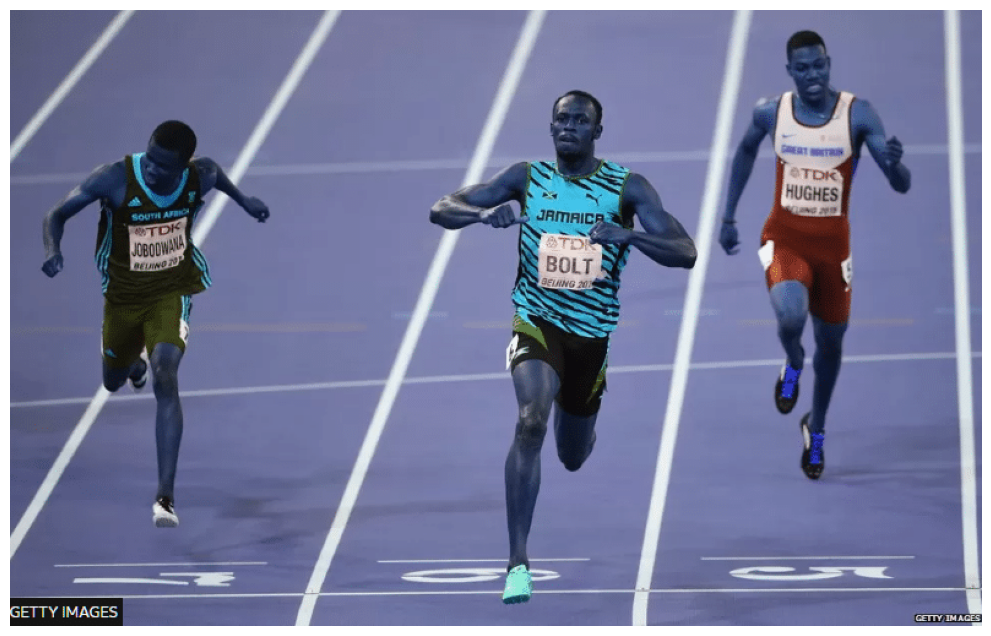

In [10]:
# Color image gray 
img = color.rgb2gray(io.imread("/home/daniel-choate/ASAR/s2/TerrainNav/Match_Demos/bolt_cropped.png"))
plt.figure(figsize=(15, 8))
plt.imshow(im, cmap="gray")
plt.axis("off")
plt.show()

In [5]:
img = np.array(img)
print(len(img[1,:]))

250


# Step 2: Calculate Gradient Images 

In [8]:
# Choose specific image 
image_fn = "/home/daniel-choate/ASAR/s2/TerrainNav/Match_Demos/bolt_cropped.png"
im = cv2.imread(image_fn)
im = np.float32(im) / 255.0

# Calculate gradient
gx = cv2.Sobel(im, cv2.CV_32F, 1, 0, ksize=1)
gy = cv2.Sobel(im, cv2.CV_32F, 0, 1, ksize=1)
print("\n Gradients in the x-direction \n", gx)
# print("\n Gradients in the y-direction \n", gy)

# Calculate gradient magnitude and direction ( in degrees )
mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
print(mag)
# print(angle)


 Gradients in the x-direction 
 [[[ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.00784314  0.01176473  0.03137255]
  [ 0.          0.          0.        ]]

 [[ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.00392157  0.         -0.02745098]
  [ 0.          0.          0.        ]]

 [[ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  ...
  [ 0.0156863   0.01960787  0.01568627]
  [ 0.         -0.01176473 -0.01568627]
  [ 0.          0.          0.        ]]

 ...

 [[ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.     

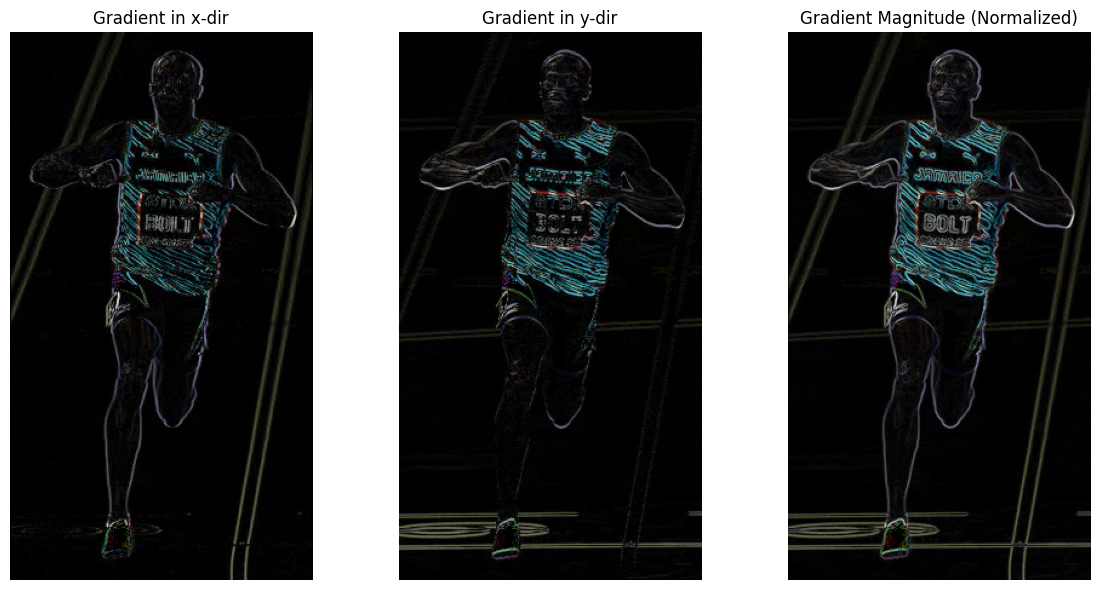

In [7]:
# Plot image gradients 

# Plot gradient magnitude in x
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(np.abs(gx), cmap='gray')
plt.title('Gradient in x-dir')
plt.axis('off')

# Plot gradient magnitude in y
# plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 2)
plt.imshow(np.abs(gy), cmap="gray")
plt.title('Gradient in y-dir')
plt.axis("off")

# Plot gradient magnitude normalized
# plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 3)
magnitude_normalized = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
plt.imshow(magnitude_normalized, cmap='gray')
# plt.imshow(mag, cmap='gray')
plt.title('Gradient Magnitude (Normalized)')
plt.axis('off')

plt.tight_layout()
plt.show()

# print("OG MAG \n", mag)
# print("\n DIF MAG \n", magnitude_normalized)